# Exercise: multi-class classification on Stack Overflow questions

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf  
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = tf.keras.utils.get_file('stack_overflow_16k', url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow')

In [3]:
os.listdir(dataset_dir)

['test', 'README.md', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
train_dir

'./stack_overflow/train'

In [5]:
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [6]:
sample_file = os.path.join(train_dir, 'python/15.txt')
with open(sample_file) as f:
    print(f.read())

"float rounding problems in blank amount = 0.002638309660058967.price = 1392.18..lowest_ask = 1391.6..result = price*amount/lowest_ask..print(result)...the above code will print out:..0.002639409271731024...however when i perform the calculation here: http://web2.0calc.com/.it gives me: 0.0026394092717310237698..so obviously blank is rounding up the result of this calculation......my question is, how do you prevent blank from rounding up result? i.e. i want result to be: 0.002639409271731023"


In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(2):
        print("Questions", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Questions b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default cons

In [9]:
raw_train_ds.class_names[0]

'csharp'

In [10]:
raw_train_ds.class_names[1]

'java'

In [11]:
raw_train_ds.class_names[2]

'javascript'

In [12]:
raw_train_ds.class_names[3]

'python'

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize='lower',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [16]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label 

In [18]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question: ", first_question)
print("Label: ", raw_train_ds.class_names[first_label])
print("Vectorized question: ", vectorize_text(first_question, first_label))

Question:  tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of 

In [19]:
print("55 => ", vectorize_layer.get_vocabulary()[55])
print("550 => ", vectorize_layer.get_vocabulary()[550])

55 =>  static
550 =>  const


In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configuring the dataset for performance

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model

In [30]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.4),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.4),
    layers.Dense(4)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

### Loss function and optimizer

In [31]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Training the model

In [32]:
epochs = 40

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=epochs
)

Epoch 1/40
200/200 [==============================] - 6s 26ms/step - loss: 1.3788 - accuracy: 0.3336 - val_loss: 1.3693 - val_accuracy: 0.4837
Epoch 2/40
200/200 [==============================] - 4s 21ms/step - loss: 1.3525 - accuracy: 0.4508 - val_loss: 1.3385 - val_accuracy: 0.5425
Epoch 3/40
200/200 [==============================] - 3s 17ms/step - loss: 1.3062 - accuracy: 0.5281 - val_loss: 1.2891 - val_accuracy: 0.5800
Epoch 4/40
200/200 [==============================] - 3s 16ms/step - loss: 1.2397 - accuracy: 0.5900 - val_loss: 1.2252 - val_accuracy: 0.6281
Epoch 5/40
200/200 [==============================] - 3s 15ms/step - loss: 1.1609 - accuracy: 0.6422 - val_loss: 1.1555 - val_accuracy: 0.6650
Epoch 6/40
200/200 [==============================] - 3s 15ms/step - loss: 1.0796 - accuracy: 0.6905 - val_loss: 1.0875 - val_accuracy: 0.6969
Epoch 7/40
200/200 [==============================] - 3s 15ms/step - loss: 1.0020 - accuracy: 0.7320 - val_loss: 1.0250 - val_accuracy: 0.7231

### Evaluating the model

In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss = ", loss)
print("Accuracy = ", accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.5412 - accuracy: 0.7968
Loss =  0.5412313938140869
Accuracy =  0.796750009059906


In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

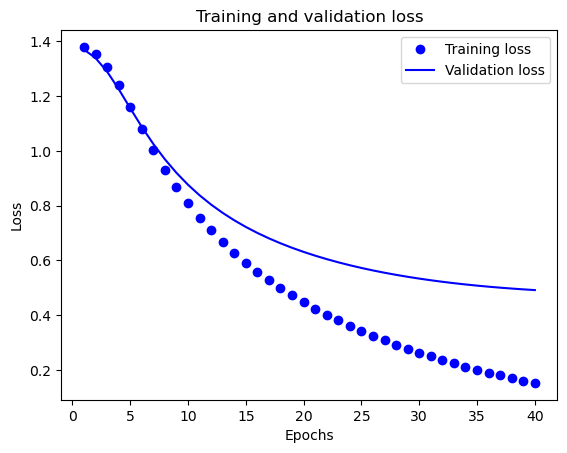

In [35]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

x_axis = range(1, len(acc) + 1) # Number of epochs for x_axis

plt.plot(x_axis, loss, 'bo', label='Training loss')
plt.plot(x_axis, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

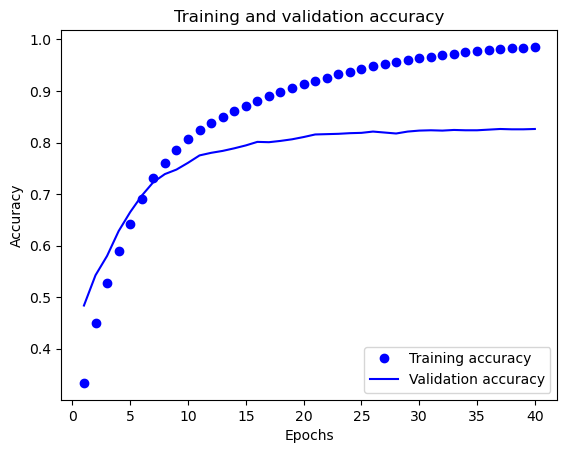

In [36]:
plt.plot(x_axis, acc, 'bo', label='Training accuracy')
plt.plot(x_axis, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [37]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)


In [38]:
loss, accuracy = export_model.evaluate(raw_test_ds)
accuracy

250/250 [==============================] - 1s 5ms/step - loss: 0.5412 - accuracy: 0.7968


0.796750009059906